In [94]:
import pandas as pd
import json
import re
import numpy as np

In [7]:
df_en = pd.read_csv("events/events_dataframe_en.csv", converters={'redirects': pd.eval, 'list_views_7_days':pd.eval})
df_en['lang'] = 'en'
df_de = pd.read_csv("events/events_dataframe_de.csv", converters={'redirects': pd.eval, 'list_views_7_days':pd.eval})
df_de['lang'] = 'de'
df = pd.concat([df_en, df_de])
df = df[(df["views_7_sum"] != 0) & (df.cat != "")]
len(df)

6210

In [23]:
with open('scraping/results/en_bingnews_1_new.json') as json_data:
    data1 = json.load(json_data)
with open('scraping/results/en_bingnews_2_new.json') as json_data:
    data2 = json.load(json_data)
data_en = {**data1, **data2}
len(data_en)

5182

In [10]:
with open('scraping/results/de_bingnews_new.json') as json_data:
    data_de = json.load(json_data)
len(data_de.keys())

1014

In [48]:
def get_hits_from_json(json_data, serp='bing_news'):
    bing_news_hits = []
    i = 0 
    for title, crawl_res in json_data.items():
        # get result string and clean
        res_string = crawl_res['1']['num_results']
        num_string = re.sub('[^0-9]', '', res_string)
        
        if len(num_string) == 0:
            #print(f'Error when parsing hits for {title}: |{res_string}|')
            num = np.nan
        else:
            num = int(num_string)
            
        bing_news_hits.append([title, num])
        
        # debug output
        if i%250 == 0:
            print(title, res_string, num_string)
        i+=1
    return pd.DataFrame(bing_news_hits, columns=['pagetitle', f'{serp}_hits'])

In [39]:
de_news_hits = get_hits_from_json(data_de)

Griechisches Referendum 2015 48 Ergebnisse 48
Pakistan-International-Airlines-Flug 661 22.500 Ergebnisse 22500
Super Bowl LII 5.990 Ergebnisse 5990
Europawahl in Portugal 2019 34 Ergebnisse 34
Deutsche Meisterschaften im Rennrodeln 2020 40.500 Ergebnisse 40500


In [40]:
en_news_hits = get_hits_from_json(data_en)

2023 South Sudanese general election 444,000 results 444000
Eckwersheim derailment 1 result 1
2016 Mexico City ePrix 393,000 results 393000
12th Africa Movie Academy Awards 1,510,000 results 1510000
Equestrian at the 2016 Summer Olympics – Team jumping 16,300 results 16300
2016 Minnesota Senate election 23 results 23
UFC on Fox: Shevchenko vs. Peña 38 results 38
2017 Durham County Council election 46 results 46
2017 Barcelona attacks 33,300 results 33300
2017 Nepalese general election 1,030,000 results 1030000
2018 Dutch Intelligence and Security Services Act referendum 17,400 results 17400
2018 Kohler Grand Prix 276,000 results 276000
2018 Toronto municipal election 58,000 results 58000
Second inauguration of Nicolás Maduro 17,100 results 17100
2019 Food City 500 222,000 results 222000
21st Quebec Cinema Awards 35,200 results 35200
2019 Kashmir earthquake 82 results 82
2019 Algerian presidential election 17,400 results 17400
2020 Idaho Republican presidential primary 15 results 15
202

In [93]:
de_news_hits.to_csv(f'scraping/results/bing_news_de.csv', index=False)
en_news_hits.to_csv(f'scraping/results/bing_news_en.csv', index=False)

# Checks

## two different runs

In [43]:
with open('scraping/results/de_bingnews.json') as json_data:
    data_old = json.load(json_data)
len(data_old.keys())

de_news_hits_old = get_hits_from_json(data_old, serp='bing_news_old')
de_news_hits_old.head()

Griechisches Referendum 2015 48 Ergebnisse 48
Eisenbahnunfall von Hitrino 0 Ergebnis 0
US Poker Open 2018 3 480 000 Ergebnisse 3480000
Europawahl in Luxemburg 2019 45 Ergebnisse 45
Amokfahrt in Trier 6 610 Ergebnisse 6610


,pagetitle,bing_news_old_hits
0,Griechisches Referendum 2015,48
1,Großer Preis von Großbritannien 2015,27400
2,Amoklauf von Leutershausen,5
3,Anschlag in Suruç 2015,11300
4,Amoklauf in Lafayette,42


In [44]:
de_merged = de_news_hits.merge(de_news_hits_old, on='pagetitle', copy=False)
de_merged.corr()

,bing_news_hits,bing_news_old_hits
bing_news_hits,1.000000,0.911506
bing_news_old_hits,0.911506,1.000000


In [91]:
de_merged_log = de_merged.copy()
de_merged_log.bing_news_hits = np.log1p(de_merged_log.bing_news_hits)
de_merged_log.bing_news_old_hits = np.log1p(de_merged_log.bing_news_old_hits)
de_merged.corr()

,bing_news_hits,bing_news_old_hits
bing_news_hits,1.000000,0.911506
bing_news_old_hits,0.911506,1.000000


## Corr with (a few) google results
Google blocked my IP after 82 attempts

In [86]:
with open('scraping/results/de_google.json') as json_data:
    data_google = json.load(json_data)
print(len(data_google.keys()))

google_news_hits = get_hits_from_json(data_google, serp='google_news')
google_news_hits.head()

1014
Griechisches Referendum 2015  
Pakistan-International-Airlines-Flug 661  
Super Bowl LII  
Europawahl in Portugal 2019  
Deutsche Meisterschaften im Rennrodeln 2020  


,pagetitle,google_news_hits
0,Griechisches Referendum 2015,NaN
1,Großer Preis von Großbritannien 2015,39900034.0
2,Amoklauf von Leutershausen,1170022.0
3,Anschlag in Suruç 2015,1450024.0
4,Amoklauf in Lafayette,1510023.0


In [63]:
google_merged = de_news_hits.merge(google_news_hits, on='pagetitle', copy=False).dropna()
print(len(google_merged))
google_merged.head()
# NOTE: only 82 retrieved here.

82


,pagetitle,bing_news_hits,google_news_hits
1,Großer Preis von Großbritannien 2015,27300,39900034.0
2,Amoklauf von Leutershausen,5,1170022.0
3,Anschlag in Suruç 2015,11300,1450024.0
4,Amoklauf in Lafayette,42,1510023.0
5,Großer Preis von Ungarn 2015,19400,6920026.0


,bing_news_hits,google_news_hits
bing_news_hits,1.000000,0.929782
google_news_hits,0.929782,1.000000


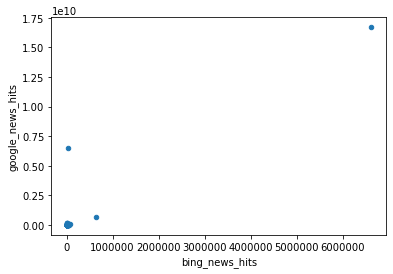

In [84]:
google_merged.plot.scatter(x='bing_news_hits', y='google_news_hits')
google_merged.corr()

,bing_news_hits,google_news_hits
bing_news_hits,1.000000,0.495871
google_news_hits,0.495871,1.000000


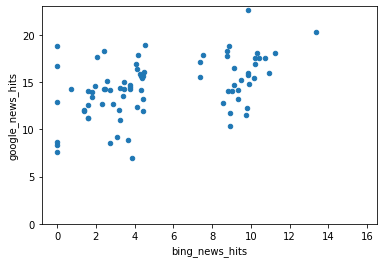

In [80]:
google_merged_log = google_merged.copy()
google_merged_log.bing_news_hits = np.log1p(google_merged_log.bing_news_hits)
google_merged_log.google_news_hits = np.log1p(google_merged_log.google_news_hits)
google_merged_log.plot.scatter(x='bing_news_hits', y='google_news_hits', ylim=(0,23))
google_merged_log.corr()